# This notebook is still under construction

In this document we summarize the methods for wavefield propagation and list the general procedures for their implementation. In particular, we will put special notes on practical problems that requires coders' attention. Scripts will be provided for illustrating the implementation of propagation equations based on the Huygens-Fresnel principle. Based on these discussions, we will demonstrate the construction of a multislice-propagation simulation program. A 3D phantom of size 128x128x128 has already been generated using the XDesign library for this purpose. 

## Overview
All of the wave propagation algorithms discussed here are derived from the well-known Fresnel diffraction integral. They are mathematically equivalent, but differ from each other when it comes to the discrete sampling condition that computers work in. In the text following, we will examine each of these methods in terms of their sampling criteria.

### The convolutional method
The Fresnel diffraction integral can be regarded as the convolution between the original wavefield `u(x, y, 0)` and a Fresnel kernel `h` as 
```
u(x, y, z) = conv(u(x, y, 0), h).
```
It can be easily seen from the diffraction integral that
```
h = exp(j * k * z) / (j * lambda * z) * exp(j * k / (2 * z) * (x**2 + y**2))
```
where `k = 2 * PI / lambda` is the wave number, and `z` is the propagation distance. The invariance of convolution informs us that
```
u(x, y, z) = conv(u(x, y, 0), h)
           = ifft(fft(u(x, y, 0) * fft(h)))
```
The latter form of the equation is of significant computational advantages as it utilize the fast Fourier transform algorithms as an efficiency booster. Depending on how we implement the Fourier transform of `h`, the convolutional methods branches into two mathematically identical but practically quite different algorithms. One could, for the first place, implement the convolution by first generating the numerical array for the convolution kernel `h`, then perform FFT to obtain its spectrum. In this way, one samples the kernel in real space; the real-space function `h` is referred to as the **impulse response**, and the above-described method is named as the **impulse reponse (IR) method**. 
As another measure, one could also analytically derive the Fourier transform of the kernel as
```
H = exp(j * k * z * sqrt(1 - lambda**2 * (u**2 + v**2)))
```
where `u` and `v` are the reciprocal space coordinates. It is suggested that both variables are sampled in the following fashion:
```
u = [-(N-1)/2 : 1 : (N-1)/2] * (1 / (2 * delta)) for N = odd
u = [-N/2 : 1 : N/2 - 1] * (1 / (2 * delta)) for N = even
```
where `N` is the wavefront array side length in number of pixels, and `delta` is the pixel size in physical units. By doing this, one samples the kernel function in Fourier space, and `H` is called the **transfer function** for the wavefront. Thus, this method is naturally referred to as the **transfer function method**. 

#### Demonstration

We shall post a small demonstration for both the Transfer Function (propTF) and Impulse Response aprroaches (propIR) to 
the above convolutional method. <br>
Refer to prop.py and sqr_beam.py for the code used in the following demonstration. <br>
Reference : Computational Fourier Optics: A MATLAB Tutorial by David George Voelz

Now we shall use the above code to provide a simple demonstration which involves propogating a square beam at 
different distances and point out which approach is appropriate to use depending on the propogation distance.


In [45]:
import numpy as np
import matplotlib.pyplot as plt
import rect as r
import prop
L1 = 0.5 #side length in m
M = 250 #number of samples
step1 = L1/M #step size in m
x1 = np.linspace(-L1/2,L1/2,M) #input support coordinates
y1 = x1
energy = 5 # in keV
wavel = 0.5*10**(-6) # wavelength of light in m
k = 2*np.pi/wavel #wavevector
w = 0.051 #width of square aperture
z = 1000 # propogation distance in meters

X1,Y1 = np.meshgrid(x1,y1)
u1 = np.multiply(r.rect(X1/(2*w)),r.rect(Y1/(2*w))) #creating the input beam profile
I1 = abs(np.multiply(u1,u1))  #input intensity profile

In the above code, we have created an input beam and propogated it using both the approaches. <br>
The input beam intensity profile is shown below.


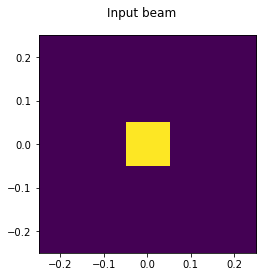

In [48]:
plt.figure()
plt.suptitle('Input beam')
plt.imshow(np.abs(I1),extent=[x1[0],x1[-1],y1[0],y1[-1]])
plt.show()

Now we will plot the results from the propogation.

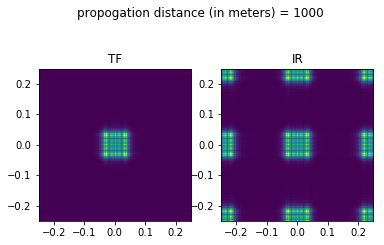

In [49]:
z = 1000 # propogation distance

ua = prop.propTF(u1,step1,L1,wavel,z) #result using TF method
Ia = abs(ua) ** 2 #TF output intensity profile

ub = prop.propIR(u1,step1,L1,wavel,z) #result using IR method
Ib = abs(ub) ** 2 #IR output intensity profile
'''
Plotting.
'''

plt.figure()
plt.suptitle('propogation distance (in meters) = '+str(z))
plt.subplot(121)
plt.imshow(abs(Ia),extent=[x1[0],x1[-1],y1[0],y1[-1]])
plt.title('TF')
plt.subplot(122)
plt.imshow(abs(Ib),extent=[x1[0],x1[-1],y1[0],y1[-1]])
plt.title('IR')
plt.show()

Next, we repeat the procedure for a number of different distances. 

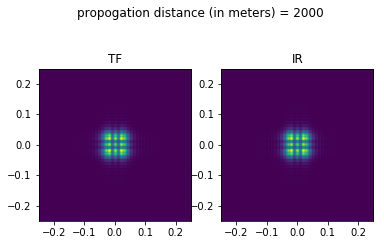

In [26]:
z = 2000 # propogation distance
ua = prop.propTF(u1,step1,L1,wavel,z) #result using TF method
Ia = np.abs(ua) ** 2 #TF output intensity profile

ub = prop.propIR(u1,step1,L1,wavel,z) #result using IR method
Ib = np.abs(ub) ** 2 #IR output intensity profile

'''
Plotting.
'''

plt.figure()
plt.suptitle('propogation distance (in meters) = '+str(z))
plt.subplot(121)
plt.imshow(np.abs(Ia),extent=[x1[0],x1[-1],y1[0],y1[-1]])
plt.title('TF')
plt.subplot(122)
plt.imshow(np.abs(Ib),extent=[x1[0],x1[-1],y1[0],y1[-1]])
plt.title('IR')
plt.show()

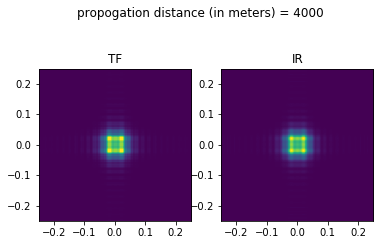

In [27]:
z = 4000 # propogation distance

ua = prop.propTF(u1,step1,L1,wavel,z) #result using TF method
Ia = np.abs(ua) ** 2 #TF output intensity profile

ub = prop.propIR(u1,step1,L1,wavel,z) #result using IR method
Ib = np.abs(ub) ** 2 #IR output intensity profile

'''
Plotting.
'''

plt.figure()
plt.suptitle('propogation distance (in meters) = '+str(z))
plt.subplot(121)
plt.imshow(abs(Ia),extent=[x1[0],x1[-1],y1[0],y1[-1]])
plt.title('TF')
plt.subplot(122)
plt.imshow(abs(Ib),extent=[x1[0],x1[-1],y1[0],y1[-1]])
plt.title('IR')
plt.show()

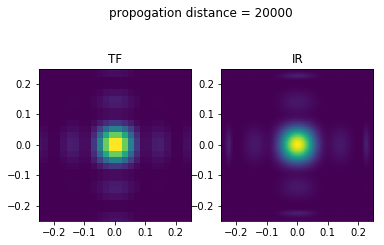

In [28]:
z = 20000 # propogation distance

ua = prop.propTF(u1,step1,L1,wavel,z) #result using TF method
Ia = np.abs(ua) ** 2 #TF output intensity profile

ub = prop.propIR(u1,step1,L1,wavel,z) #result using IR method
Ib = np.abs(ub) ** 2 #IR output intensity profile

'''
Plotting.
'''

plt.figure()
plt.suptitle('propogation distance = '+str(z))
plt.subplot(121)
plt.imshow(abs(Ia),extent=[x1[0],x1[-1],y1[0],y1[-1]])
plt.title('TF')
plt.subplot(122)
plt.imshow(abs(Ib),extent=[x1[0],x1[-1],y1[0],y1[-1]])
plt.title('IR')
plt.show()

As we can see depending on the propogation distance, we sometimes see artifacts in one of the approaches. <br>
Below is a table (taken from the reference book) to help us decide which version of the convolution algorithm we must use. 

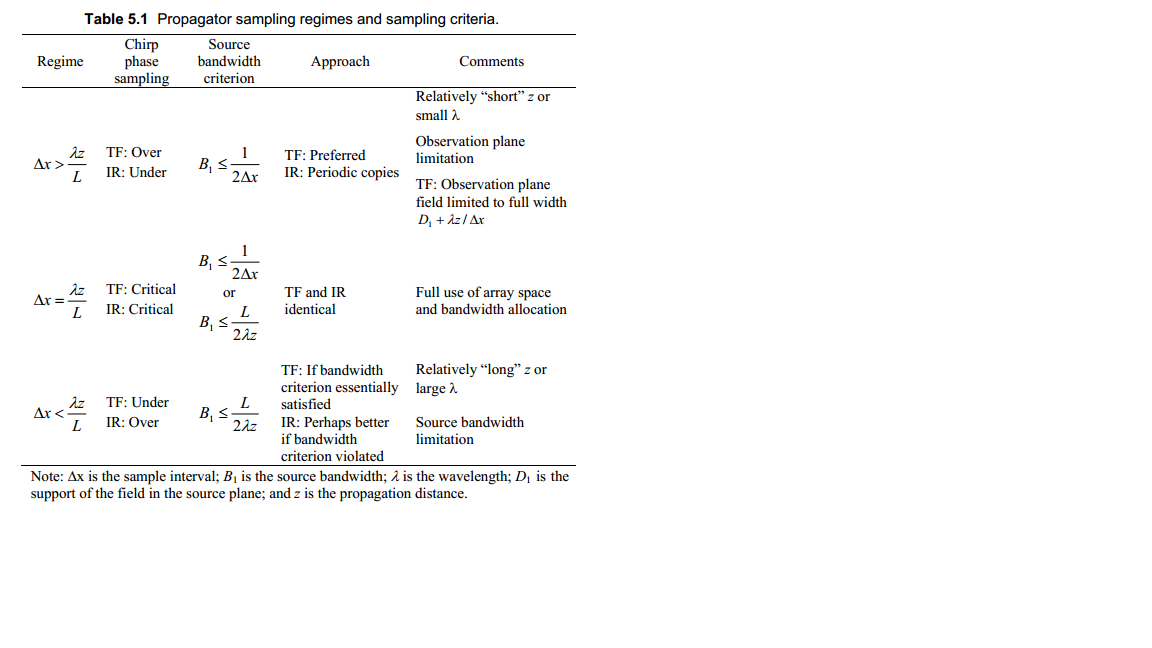

In [7]:
from IPython.display import Image
Image(filename='table_5_1.png') 

The table above reveals the border line between the most-suitable regime for the TF and the IR method. It is sometimes more convenient to view the judging criterion as a critical propagation distance, `z_crit`, as
```
z_crit = L^2 / (lambda * N)
```
where `L` is the extent of the incident wavefield, and `N` is the number of pixels along each side. Appaerently, TF is a more favorable algorithm when the propagation distance is beyond `z_crit`. 

### The single FT method

By taking out an exponential factor, the Fresnel diffraction integral becomes the Fourier transform of the product between the wavefront and a quadratic phase factor:
```
u(x, y, z) = fft(u(x, y, 0) * exp(j * k / (2 * z) * (x**2 + y**2))) * exp(j * k * z) / (1j * lambda * z) * exp(j * k / (2 * z) * (u**2 + v**2)) * delta**2
```
where `delta` is the pixel size on the source plane. The purpose of the `delta**2` is to correct the physical unit in the Fourier transform integral, which is assumed dimensionless by most FFT algorithms. A demonstration for the rectangle wave is provided below.

5e-07 10000 0.002


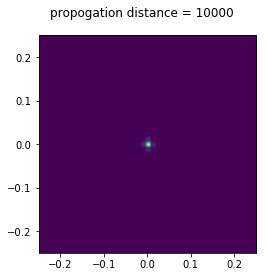

In [8]:
z = 10000 # propogation distance

ua = prop.prop1FT(u1,step1,L1,wavel,z) #result using TF method
Ia, L2 = np.abs(ua) ** 2 #TF output intensity profile

'''
Plotting.
'''

plt.figure()
plt.suptitle('propogation distance = '+str(z))
plt.subplot(111)
plt.imshow(Ia,extent=[x1[0],x1[-1],y1[0],y1[-1]])
plt.show()

The Nyquist criterion again stipulates that the best suitable regime for the single FT method is `z > L^2 / (lambda * N)`. However, the single FT method owns unique properties that is not shared by the convolutional methods. The most notable characteristic of the single FT method is that the sampling interval on the observation plane is changed to
```
delta_2 = lambda * z / (delta_1 * N)
```
so that for propagation distance longer than `delta_1^2 * N / lambda`, the image is demagnified to compensate for beam divergence. 
Another issue that requires attention is that the single-Fourier method works well only for a bright object in dark background. If the wavefront at the source plane contains a non-zero plane wave component, diffraction fringes would be created from this plane wave as well. This is most problematic when the method is used for propagating the exiting wave produced by multislice simulation as in this case one usually initialize the incident wavefront to be with unity amplitude and zero phase - that is an array of `1 + 0.j`. After transmitting through the object, the wave is endowed with structural information of the specimen, but also contains a plane wave component whose magnitude is generally much larger than the perturbation caused by the object. For large free space propagation distance, the single Fourier method effectively put the space-limited wavefront into a larger space filled with zeros, causing the plane wave component to diffract inwards and outwards, the Fresnel fringes generated by which would overwhelm any object information. This problem should be addressed by decomposing the input wavefront into a plane wave and a "dark background" wave with specimen perturbation. We demonstrate the proposed solution with an example.  

We first load a complex wavefront that was produced by propagating a plane wave through a 3D object. One can see that some diffraction fringes are already present near the edges of the specimen. 

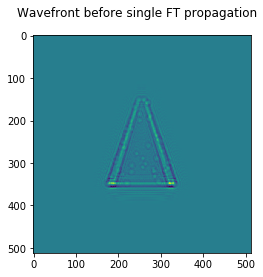

In [29]:
u1 = np.load('prop_demos/exiting.npy')
I1 = np.abs(u1) ** 2
plt.figure()
plt.suptitle('Wavefront before single FT propagation')
plt.imshow(np.abs(I1))
plt.show()
delta = 1
kev = 5
lmbda_nm = 1.24 / kev
N = u1.shape[0]

With an energy of 5 keV and a voxel size of 1 nm, the critical distance that makes the sampling rate equal at both source plane and observation plane is 

In [30]:
z_eq_samp = delta ** 2 * N / lmbda_nm
print z_eq_samp

2064.51612903


Propagating the wavefront without any preprocessing is equivalent to propagating a space-limited plane wave with perturbations in dark vacuum. All specimen information is overwhelmed by the self-diffraction of the carrier wave.

(0.248, 5000, 1)


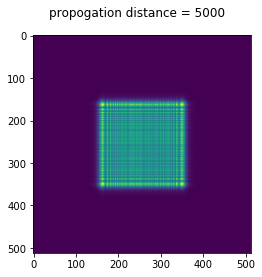

In [31]:
z = 5000 # propogation distance

ua = prop.prop1FT(u1, delta, delta * N, lmbda_nm, z) #result using TF method
Ia, L2 = np.abs(ua) ** 2 # output intensity profile

'''
Plotting.
'''

plt.figure()
plt.suptitle('propogation distance = '+str(z))
plt.subplot(111)
plt.imshow(Ia)
plt.show()

The solution to this problem is to decompose the input wavefront into a plane wave component and a perturbation component, propagate them individually, then sum them together. The plane wave can be propagated analytically, which simply requires the multiplication with a factor `exp(j * k * z * sqrt(1 - lambda ** 2 * (u_max**2 - v_max**2)))`, where `u_max = 1 / (2 * delta)`, and similar for `v_max`.

(0.248, 5000, 1)


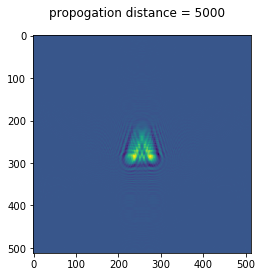

In [32]:
udc = u1[0, 0]
u1 = u1 - u1[0, 0]
ua = prop.prop1FT(u1, delta, delta * N, lmbda_nm, z)
u_max = v_max = 1 / (2 * delta)
k = 2 * np.pi / lmbda_nm
udc *= np.exp(1j * k * z * np.sqrt(1 - lmbda_nm ** 2 * (u_max**2 - v_max**2)))
ua += udc
Ia, L2 = np.abs(ua) ** 2 # output intensity profile

plt.figure()
plt.suptitle('propogation distance = '+str(z))
plt.subplot(111)
plt.imshow(Ia)
plt.show()

Now the specimen information is well preserved in the resulting wavefront.

### Fraunhofer Propogation

We shall now discuss Fraunhofer propogation which is approriate for determing the wavefiled at large distances from 
the source plane. Thus, this mode of propogation is applicable when the Fresnel number is << 1.
<br>
We use the subscript 1 for all quantities relating to the source plane and the subscript 2 for all quantities relating to the observation plane.
<br><br>
$$u(x, y, z) = \frac{exp(jkz)}{jkz}*exp\lbrack j * \frac{k}{(2z)}*(x^{2}+y^{2})\rbrack \iint U_{1}(x_{1},y_{1})*exp\lbrack -j * \frac{2\pi}{(2z)}*(x_{2}x_{1}+y_{2}y_{1})\rbrack dx_{1}dy_{1}$$
<br><br>
One thing to note when performing Fraunhofer propogation is that the length and sampling sizes of the observation plane are not equal to those of the source plane. 
<br><br>
$$L_{2} = \frac {\lambda z}{\triangle x_{1}} \quad and \quad  \triangle x_{2} = \frac{\lambda z}{L_{1}}$$
<br><br>
Now, let us illustrate the above with an example. We now take the source half width down to 0.011 m and a propogation distance of 2000 m. Fresnel number = 0.12 . 

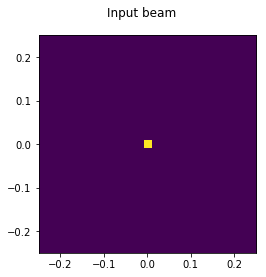

In [46]:
w = 0.011 #width of square aperture
X1,Y1 = np.meshgrid(x1,y1)
u1 = np.multiply(r.rect(X1/(2*w)),r.rect(Y1/(2*w))) #creating the input beam profile
I1 = abs(np.multiply(u1,u1))  #input intensity profile
plt.figure()
plt.suptitle('Input beam')
plt.imshow(np.abs(I1),extent=[x1[0],x1[-1],y1[0],y1[-1]])
plt.show()

Now, we plot the output wavefield. Note that we plot the third root of the output wave to increase contrast. 

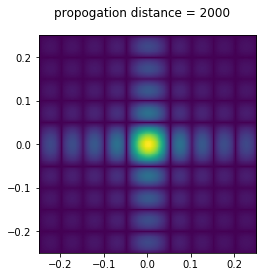

In [47]:
z = 2000 # propogation distance

u2,L2 = prop.propFF(u1,step1,L1,wavel,z) #result using TF method
I2 = np.abs(u2) ** 2 #TF output intensity profile

'''
output grid
'''
x2 = np.linspace(-L2/2.,L2/2.,M) #input support coordinates
y2 = x2
X2,Y2 = np.meshgrid(x2,y2)


'''
Plotting.
'''

plt.figure()
plt.suptitle('propogation distance = '+str(z))
plt.imshow(abs(I2)**(1./3),extent=[x2[0],x2[-1],y2[0],y2[-1]])
plt.show()

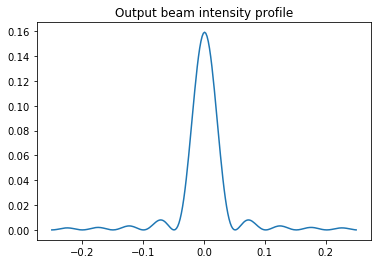

In [48]:
plt.figure()
plt.plot(x2,I2[126,:])
plt.title('Output beam intensity profile')
plt.show()